# Models with extra features and no weights

In [ ]:
import os

os.chdir('Models_no_weights')

In [59]:

#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib.patches import Polygon
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import keras
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from keras.layers import Dense, Dropout
from keras import Sequential
from tensorflow.keras.metrics import AUC
from tensorflow import random    
from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}
import pickle
## read data 
CIP_data_no_drop = pd.read_csv("/Users/rem76/Documents/ML_Models/GISP_data_initial/CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP',
       'Susceptible', 'REGION', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION',
       'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75',
       'Trend_N_greater_75'],
      dtype='object')


In [56]:


################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# logistic regression 
best_hyperparameters_by_year = {}

space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}

# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_nn,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models_sd = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))


oversample = RandomOverSampler(sampling_strategy='minority', random_state=10)


def get_feature_effects(all_features, important_features, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    feature_importances = []
    for feature in all_features:
        if feature in important_features:
            feature_importances.append(PI.importances_mean[important_features.index(feature)])
        else:
            feature_importances.append(0)
    return feature_importances

def get_best_features(feature_names, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=1, random_state=10
    )
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - PI.importances_std[q] >0:
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    return important_features


def get_best_hyperparameters(model, cv, space, X_train, y_train):
    search = RandomizedSearchCV(
        model, space, scoring="roc_auc", n_iter=100, n_jobs=-1, cv=cv, random_state=1
    )
    result = search.fit(X_train, y_train)
    return result.best_params_

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


In [87]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=10)

def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[
        feature_names
    ]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)
    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev)

def get_feature_effects(all_features, important_features, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit,  X_train, y_train, n_repeats=10, random_state=0
    )
    feature_importances = []
    for feature in all_features:
        if feature in important_features:
            feature_importances.append(PI.importances_mean[important_features.index(feature)])
        else:
            feature_importances.append(0)
    return feature_importances

def get_best_features(feature_names, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit,  X_train, y_train, n_repeats=10, random_state=0
    )
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - PI.importances_std[q] >0:
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    return important_features

def get_feature_effects_sd(feature_names, important_features,model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=42
    )

    return PI.importances_std

def get_best_hyperparameters(model, cv, space, X_train, y_train):
    search = RandomizedSearchCV(
        model, space, scoring="roc_auc", n_iter=20, n_jobs=-1, cv=cv, random_state=1
    )
    result = search.fit(X_train, y_train)
    return result.best_params_

In [88]:
## Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)

i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    if year == 2005: 
    ## before fitting the model, do hyperparameter tuning 
        best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 


    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    print(ROC)
    i += 1

2005


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6713647937292515
2006
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7163785879790616
2007
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6670659966869423
2008
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6482200693665736
2009
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.670041997845015
2010
Hyperparameters1
0.6804865442021966


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

In [91]:
## Just RF
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

space = dict()
space['n_estimators'] = np.arange(1, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 100, 1)
space['min_samples_leaf'] = np.arange(1, 100, 1)
i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)
    
     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)

    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2005
Oversample
Oversample
2006
Oversample
Oversample
2007
Oversample
Oversample
2008
Oversample
Oversample
2009
Oversample
Oversample
2010
Oversample
Oversample


In [93]:
def get_best_features_tensor_flow(feature_names, model_fit, X_train, y_train, n_repeats=10):
    def calculate_score(X, y):
        y_pred = model_fit.predict(X)
        return roc_auc_score(y, y_pred)  # Replace 'roc_auc_score' with your desired metric

    baseline_score = calculate_score(X_train, y_train)
    important_features = []

    for feature in feature_names:
        X_permuted = X_train.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        permuted_score = np.mean([calculate_score(X_permuted, y_train) for _ in range(n_repeats)])
        importance = baseline_score - permuted_score

        if importance > 0:  # Only consider features that improve the score
            important_features.append(feature)

    return important_features

def get_feature_effects_sd_tensor_flow(feature_names, important_features, model_fit, X_train, y_train, n_repeats=10):
    def calculate_score(X, y):
        y_pred = model_fit.predict(X)
        return roc_auc_score(y, y_pred)  # Replace 'roc_auc_score' with your desired metric

    baseline_score = calculate_score(X_train, y_train)
    feature_effects_sd = {}

    for feature in important_features:
        X_permuted = X_train.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        permuted_scores = [calculate_score(X_permuted, y_train) for _ in range(n_repeats)]
        effect_sd = np.std(permuted_scores)

        feature_effects_sd[feature] = effect_sd

    return feature_effects_sd

def get_feature_effects_tensor_flow(all_features, important_features, model_fit, X_train, y_train, n_repeats=10):
    def calculate_score(X, y):
        y_pred = model_fit.predict(X)
        return roc_auc_score(y, y_pred)  # Replace 'roc_auc_score' with your desired metric

    baseline_score = calculate_score(X_train, y_train)
    feature_importances = []

    for feature in all_features:
        if feature in important_features:
            X_permuted = X_train.copy()
            X_permuted[feature] = np.random.permutation(X_permuted[feature])

            permuted_scores = [calculate_score(X_permuted, y_train) for _ in range(n_repeats)]
            effect = baseline_score - np.mean(permuted_scores)
        else:
            effect = 0

        feature_importances.append(effect)

    return feature_importances

def get_best_hyperparameters_tensorflow(estimator, param_space, cv, X_train, y_train):
    grid = RandomizedSearchCV(estimator, param_space, scoring="roc_auc", n_iter=10, n_jobs=-1, cv=cv, random_state=1)
    grid_result = grid.fit(X_train, y_train)
    params = grid_result.best_params_
    return params


In [ ]:

def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(len(feature_names),), kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
    return model

kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros', dropout=0.1, dense_nparams=8, random_state=10)

estimator = Pipeline([
    ('ss', StandardScaler()),  # Use StandardScaler for numerical features
    ("kc", kears_estimator)
])

# Define the grid search parameters
param_grid = {
    'kc__dense_nparams': [2, 4, 6, 8, 10, 12, 14, 16],
    'kc__batch_size': [5, 10, 15, 20],
    'kc__optimizer': ['Adamax'],
    'kc__dropout': [0.075, 0.03, 0.05, 0.04, 0.025, 0]
}


test_years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year));

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)];
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])];

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type);
    best_hyperparameters1 = get_best_hyperparameters_tensorflow(estimator = estimator, param_space = param_grid, cv = cv, X_train = X_train, y_train = y_train);
    model_nn = create_model(optimizer=best_hyperparameters1['kc__optimizer'], init='uniform', dropout=best_hyperparameters1['kc__dropout'], dense_nparams=best_hyperparameters1['kc__dense_nparams']);

    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_nn.fit(X_train, y_train, epochs=10, batch_size=best_hyperparameters1['kc__batch_size'], verbose = 0);
    #model_fit = model_nn.copy()
    ## now also need to do feature engineering
    important_features = get_best_features_tensor_flow(feature_names, model_nn, X_train, y_train, n_repeats=10);
    best_features_by_year[model_type].__setitem__(year, important_features);
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects_tensor_flow(feature_names, important_features, model_nn, X_train, y_train); #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects_sd_tensor_flow(feature_names, important_features, model_nn, X_train, y_train); #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type);
    def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
        model = Sequential()
        model.add(Dense(dense_nparams, activation='relu', input_shape=(len(important_features),), kernel_initializer=init))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
        return model
    kears_estimator = KerasClassifier(model=create_model, verbose=0, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)
    estimator = Pipeline([
       ('ss', StandardScaler()),
        ("kc", kears_estimator)
    ])
    best_hyperparameters2 = get_best_hyperparameters_tensorflow(estimator = estimator, param_space = param_grid, cv = cv, X_train = X_train, y_train = y_train);
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) ;
    model_nn = create_model(optimizer=best_hyperparameters2['kc__optimizer'], init='uniform', dropout=best_hyperparameters2['kc__dropout'], dense_nparams=best_hyperparameters2['kc__dense_nparams']);

    print("Hyperparameters2")
    ## fit model w/hyperparameters 
    model_nn.fit(X_train, y_train, epochs=100, batch_size=best_hyperparameters2['kc__batch_size'], verbose = 0);

    # Make predictions on test data
    y_predict_proba = model_nn.predict(X_test);

    # Calculate AUROC on test data
    auc_metric = keras.metrics.AUC(num_thresholds=100);
    auc_metric.update_state(y_test, y_predict_proba);
    auroc = auc_metric.result().numpy();
 
    ROC_by_year[model_type].__setitem__(year, auroc);

    print(auroc)
    i += 1;

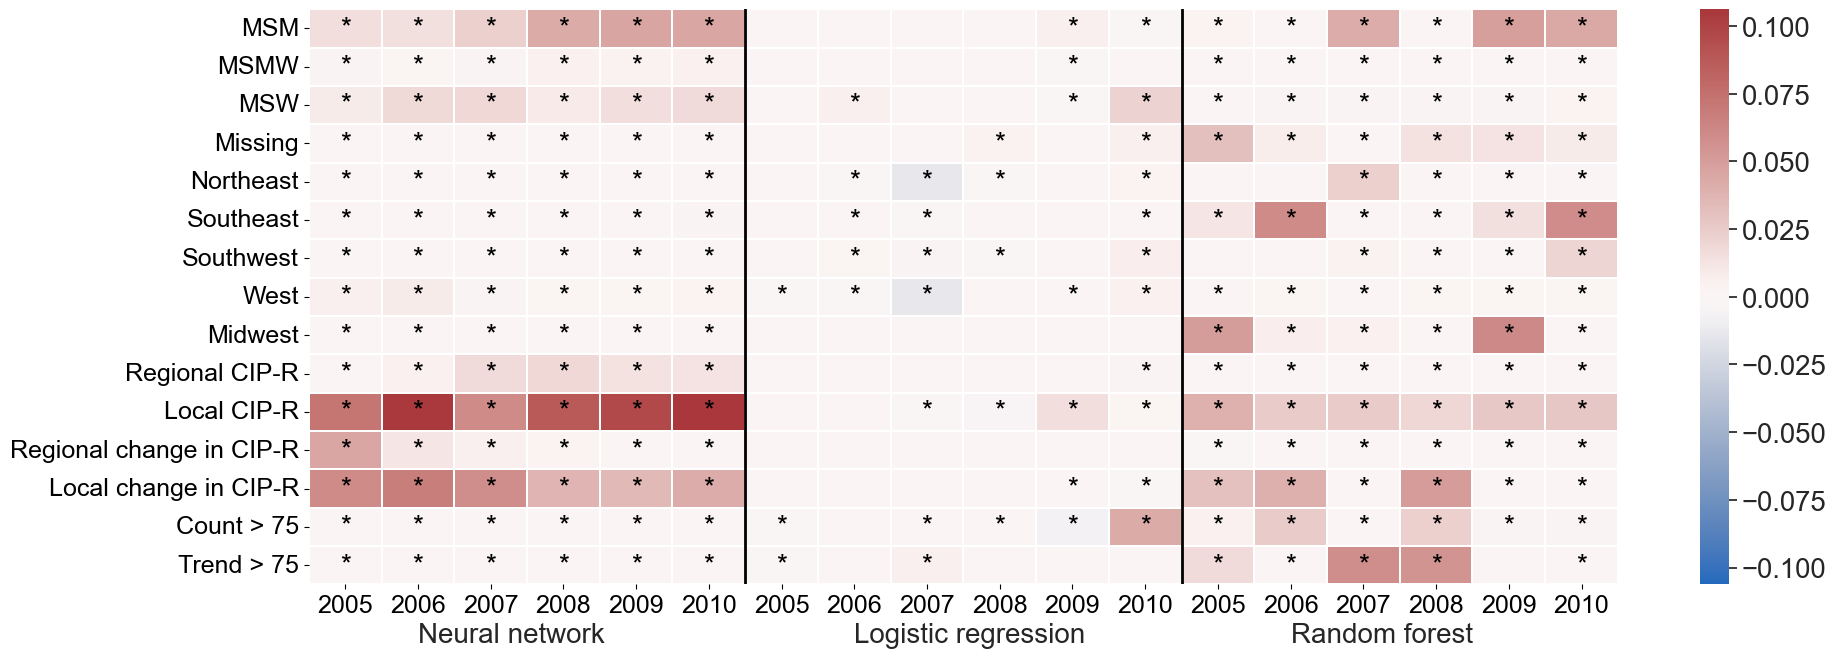

In [98]:
### Graph 2 of important features 
## Figure 1: Graph of important features

fig, ax = plt.subplots(figsize=(20,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*3
y_axis_labels = ['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R', 'Count > 75', 'Trend > 75']

ax.tick_params(axis='both', which='major', labelsize=18)
included_features = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

model_types = [0, 1, 2]
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

for model in model_types:
    if model == 0:
             j = 6
    elif model == 1:
             j = 12
    elif model == 2:
             j =0
    for year in test_years:
        matched_indices = np.where(np.isin(feature_names, list(set(best_features_by_year[model][year]))))[0]

        for i in matched_indices:
                ax.text(j + 0.5, i + 0.5, '*', color='black', size=20, ha='center', va='center')
        j +=1
sb.heatmap(imporances_all_models,fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.max()).max(), vmax = abs(imporances_all_models.max()).max())
ax.text((ax.get_xlim()[1])/18 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Neural network", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 7.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 13.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/18 * 6, color = "black", linewidth = 2)
ax.axvline((ax.get_xlim()[1])/18 * 12, color = "black", linewidth = 2)
plt.tight_layout()

#plt.show()

# Data

In [101]:
#imporances_all_models.to_csv("Importances_all_models_no_weight.csv")
ROC_by_year= [{2005: 0.6713647937292515, 2006: 0.7163785879790616, 2007: 0.6670659966869423, 2008: 0.6482200693665736, 2009: 0.670041997845015, 2010: 0.6804865442021966}, {2005: 0.7581056828044779, 2006: 0.7588948182022759, 2007: 0.692821796182484, 2008: 0.6967250371606644, 2009: 0.6812978494150521, 2010: 0.6851098328433621}, {2005: 0.8173363, 2006: 0.84125596, 2007: 0.7833694, 2008: 0.77714425, 2009: 0.7557434, 2010: 0.7670177}]
best_features_by_year = [{2005: ['West', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2006: ['West', 'Northeast', 'Southwest', 'Southeast', 'MSW'], 2007: ['West', 'PREV_CLINIC', 'Northeast', 'Southeast', 'Trend_N_greater_75', 'Southwest', 'Count_Exceeds_75'], 2008: ['PREV_CLINIC', 'Southwest', 'Northeast', 'Count_Exceeds_75', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'MSM', 'DELTA_CLINIC', 'MSW', 'Count_Exceeds_75', 'MSMW'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'West', 'Southeast', 'Oth/Unk/Missing', 'PREV_REGION', 'Southwest', 'MSM', 'Northeast', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'Count_Exceeds_75', 'MSMW', 'Southeast', 'Midwest', 'Trend_N_greater_75', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Oth/Unk/Missing', 'Southeast', 'Midwest', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Midwest', 'Trend_N_greater_75', 'Southwest', 'Northeast', 'Count_Exceeds_75', 'Southeast'], 2008: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'Midwest', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'West', 'Count_Exceeds_75', 'Southwest', 'Southeast'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'West', 'Southwest', 'Oth/Unk/Missing', 'Midwest', 'Count_Exceeds_75', 'Southeast', 'Northeast'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'West', 'Midwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75', 'Southwest', 'Northeast', 'Trend_N_greater_75']}, {2005: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2006: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2007: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2008: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2009: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2010: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']}]
best_hyperparameters_by_year = [{2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2009: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2010: {'solver': 'liblinear', 'penalty': 'l2', 'C': 34.34}}, {2005: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2006: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2007: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}, 2008: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2009: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2010: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 6, 'kc__batch_size': 15}}, {2005: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2006: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2007: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}, 2008: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2009: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2010: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 6, 'kc__batch_size': 15}}]

[{2005: 0.6713647937292515, 2006: 0.7163785879790616, 2007: 0.6670659966869423, 2008: 0.6482200693665736, 2009: 0.670041997845015, 2010: 0.6804865442021966}, {2005: 0.7581056828044779, 2006: 0.7588948182022759, 2007: 0.692821796182484, 2008: 0.6967250371606644, 2009: 0.6812978494150521, 2010: 0.6851098328433621}, {2005: 0.8173363, 2006: 0.84125596, 2007: 0.7833694, 2008: 0.77714425, 2009: 0.7557434, 2010: 0.7670177}]
[{2005: ['West', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2006: ['West', 'Northeast', 'Southwest', 'Southeast', 'MSW'], 2007: ['West', 'PREV_CLINIC', 'Northeast', 'Southeast', 'Trend_N_greater_75', 'Southwest', 'Count_Exceeds_75'], 2008: ['PREV_CLINIC', 'Southwest', 'Northeast', 'Count_Exceeds_75', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'MSM', 'DELTA_CLINIC', 'MSW', 'Count_Exceeds_75', 'MSMW'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'West', 'Southeast', 'Oth/Unk/Missing', 'PREV_REGION', 'Southwest', 'MSM', 'Northeast', 'Count_Exceeds_75']}, {2005: ['PREV

# Bootstrapping 

In [ ]:
def calculate_percentiles(iterations, ROC_actual, test_data, model_type, y_test):
    bootstrapped_stats = []
    for j in range(iterations):
        model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_no_dev_{model_type}_{year}_{j}.sav"
        X_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_X_no_dev_{model_type}_{year}_{j}.csv"
        
        X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:]]
        
        if model_type == 2:
            model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_no_dev_{model_type}_{year}_{j}"
            model_fit = keras.models.load_model(model_name)
        else:
            model_fit = pickle.load(open(model_name, 'rb'))

        y_bootstrap_predict = model_fit.predict(X_test_for_bootstrap)
        ROC_AUC_bootstrap_test_performance = roc_auc_score(y_test, y_bootstrap_predict) 
        
        difference = ROC_AUC_bootstrap_test_performance - ROC_actual
        bootstrapped_stats.append({'Difference': difference})

    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

    alpha = 0.05
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile

def bootstrap_auROC_no_dev(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
    bootstrapped_stats = []

    for i in range(iterations):
        sample_train = train_data.sample(frac=1, replace=True)
        X_sample_train = sample_train[important_features]
        y_sample_train = 1 - sample_train['Susceptible']

        if model_type in [1, 2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train, y_sample_train)

        model.fit(X_sample_train, y_sample_train, epochs=100, batch_size=32, verbose=0)

        model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_no_dev_{model_type}_{year}_{i}"
        X_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_X_no_dev_{model_type}_{year}_{i}.csv"
        y_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_y_no_dev_{model_type}_{year}_{i}.csv"

        X_sample_train.to_csv(X_data_name)
        y_sample_train.to_csv(y_data_name)
        keras.models.save_model(model, model_name)

        X_test_bootstrap = test_data[important_features]
        y_bootstrap_predict = model.predict(X_test_bootstrap)
        ROC_AUC_bootstrap_test_performance = roc_auc_score(y_test, y_bootstrap_predict)

        difference = ROC_AUC_bootstrap_test_performance - ROC_actual
        bootstrapped_stats.append({'Difference': difference})

    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

    alpha = 0.05
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile



def bootstrap_auROC_no_dev_tensorflow(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
    # 1. Find apparent model performance
    bootstrapped_stats = []

    
    for i in range(iterations):
        # 2. (A) Sample all individuals from training data w/replacement
        sample_train = train_data.sample(frac = 1, replace=True)

        X_sample_train = sample_train[important_features]
        y_sample_train = 1 - sample_train['Susceptible']

        if model_type in [1, 2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train, y_sample_train)

        # (B) Predictive model w/o feature selection
        X_test_bootstrap = test_data[important_features]

        model.fit(X_sample_train, y_sample_train, epochs=100, batch_size=32, verbose=0)

        model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_no_dev_{model_type}_{year}_{i}"
        X_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_X_no_dev_{model_type}_{year}_{i}.csv"
        y_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_y_no_dev_{model_type}_{year}_{i}.csv"
        weights_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP_no_weights/CIP_bootstrap_weights_{model_type}_{year}_{i}.csv"

        X_sample_train.to_csv(X_data_name)
        y_sample_train.to_csv(y_data_name)
        keras.models.save_model(model,model_name)
        # (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
        y_bootstrap_predict = model.predict(X_test_bootstrap)
        ROC_AUC_bootstrap_test_performance = roc_auc_score(y_test, y_bootstrap_predict)

        # (D) Calculate estimate of variance by getting (B) - (C)
        difference = ROC_AUC_bootstrap_test_performance - ROC_actual

        bootstrapped_stats.append({
            'Difference': difference
        })

    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

    # Step 3: Get average optimization
    lower_quartile, upper_quartile = np.percentile(bootstrapped_stats["Difference"], [2.5, 97.5])

    # Step 4: Get optimization-corrected performance
    alpha = 0.05
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile


iterations = 100

In [ ]:
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]

In [ ]:
## RF bootstrapping 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]

    # Merge the 'weight' column back to the original DataFrame
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
   
    model_name = "CIP_rf_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_rf_" + str(year) + ".sav" 
    pickle.dump(model_rf, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_test)

    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)